# Annual Messages to Congress on the State of the Union
Discription of Data (Wikipedia):
The State of the Union Address (sometimes abbreviated to SOTU) is an annual message delivered by the president of the United States to the U.S. Congress near the beginning of each calendar year on the current condition of the nation. The message typically includes reports on the nation's budget, economy, news, agenda, achievements and the president's priorities and legislative proposals.

## Before You Run



### Google Colab Notice:
- what is necessary to run this notebook on google colab: (the others are installed default) 
- please make sure you reseted your runtime after installing the libraries. In the colab you can find it in the Runtime menu.

In [1]:
# import nltk
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('punkt')
# ! pip install gensim==4.0.0
# ! pip install pyLDAvis==3.3.1
# ! pip install numpy==1.21.4
# ! pip install pandas==1.3.5 

### Data Notice:

Set the path of stored data into `PATH`, if you dont have any data, run `Download.ipynb` (also you can uncomment the cell bellow)

In [2]:
# ! pip install runipy
# ! runipy Download.ipynb

In [3]:
PATH = 'SOTU_data' # path of stored data

## Load Data

In [4]:
# import libraries
import csv
import warnings
warnings.filterwarnings("ignore")

Save Metadata into dicts/list/dataframes
- `file_date` -> map of file name: date of speach (e.g, '0.txt': '6-Jan-1945')
- `file_president` -> map of file name: president namae (e.g, '0.txt': 'Franklin D. Roosevelt')
- `date_list` list of all dates (just year) in order

In [5]:
file_date = {} # a dict to store file_name : date map
file_president = {} # a dict to store file_name: president_name
date_list = [] # date list in order

# open metadata information 
with open(PATH + '/information.csv', 'r') as c:
    csv_reader = csv.reader(c)
    header = next(csv_reader)
    if header != None:
        for row in csv_reader:
            # save to file_date dict 
            file_date[row[0]] = row[2]
            date_list.append(row[2].split(', ')[-1])            
            # save to file_president dict
            file_president[row[0]] = row[4]

Open stored txt files and save into a dict
- `file_document` -> map of file name: text of file
- `president_document` -> map of president name: concatenation of all texts related to that president 
- `corpus` -> concatenation of all texts

In [6]:
file_document = {} # a dict to store file_name : document text map
president_document = {} # a dict to store president_name: concatenation of documents text 

corpus :str = "" # a corpus of all texts


# building key and type of president_document dict
for president_name in set(file_president.values()):
    president_document[president_name] = ""

# store each content
for file_name in file_date.keys():
    with open(PATH + '/speaches/' + file_name) as f:
        content = ' '.join(f.read().splitlines())
    file_document[file_name] = content
    president_document[file_president[file_name]] = president_document[file_president[file_name]] + content
    corpus = corpus + content

### Text Sample

a text sample (1000 first characters) from `0.txt` file:

In [7]:
doc_sample = file_document['0.txt'][0:1000]
doc_sample 

' To the Congress: In considering the State of the Union, the war and the peace that is to follow are naturally uppermost in the minds of all of us. This war must be waged—it is being waged—with the greatest and most persistent intensity. Everything we are and have is at stake. Everything we are and have will be given. American men, fighting far from home, have already won victories which the world will never forget. We have no question of the ultimate victory. We have no question of the cost. Our losses will be heavy. We and our allies will go on fighting together to ultimate total victory. We have seen a year marked, on the whole, by substantial progress toward victory, even though the year ended with a setback for our arms, when the Germans launched a ferocious counter-attack into Luxembourg and Belgium with the obvious objective of cutting our line in the center. Our men have fought with indescribable and unforgettable gallantry under most difficult conditions, and our German enemi

a text sample (1000 first characters) from 'Donald J. Trump':

In [8]:
president_sample = president_document['Donald J. Trump'][0:1000]
president_sample

" The President. Mr. Speaker, Mr. Vice President, Members of Congress, the First Lady of the United States, and my fellow Americans: Less than 1 year has passed since I first stood at this podium, in this majestic Chamber, to speak on behalf of the American people and to address their concerns, their hopes, and their dreams. That night, our new administration had already taken very swift action. A new tide of optimism was already sweeping across our land. Each day since, we have gone forward with a clear vision and a righteous mission: to make America great again for all Americans. Over the last year, we have made incredible progress and achieved extraordinary success. We have faced challenges we expected and others we could never have imagined. We have shared in the heights of victory and the pains of hardship. We have endured floods and fires and storms. But through it all, we have seen the beauty of America's soul and the steel in America's spine. Each test has forged new American h

## Per-process Data


In [9]:
# import libraries
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import regexp_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
from string import punctuation
from nltk.tokenize import sent_tokenize


### Tokenzier

In [10]:
# modified version of http://stackoverflow.com/questions/36353125/nltk-regular-expression-tokenizer
pattern = r'''(?x)          # set flag to allow verbose regexps
        (?:[a-zA-Z]\.)+(?:[a-zA-Z])?        # abbreviations, e.g. U.S.A. or u.s.a. or U.S or
      | \w+(?:[-]\w+)*        # words with optional internal hyphens
      | \$?\d+(?:\.\d+)?%?\s?  # currency and percentages, e.g. $12.40, 82%
      | \.\.\.              # ellipsis
      | [][.,;"'?():_`-]    # these are separate tokens; includes ], [
    '''

pattern = re.compile(pattern)

# how to use
text_sample_token = ''
sample_tokenized = regexp_tokenize(text_sample_token, pattern)


def tokenizer(text):
    return regexp_tokenize(text, pattern)

sample of usage of `tokenizer`:

In [11]:
tokenizer('That U.S.A. poster-print the U.S costs $12.40 amir.')

['That',
 'U.S.A.',
 'poster-print',
 'the',
 'U.S',
 'costs',
 '$12.40 ',
 'amir',
 '.']

### Lemmatizer

In [12]:
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


def lemmatizer_costum(word, pos_tagger_lem=False):
    # if pos_tagger_lem=True the function becomes slow
    if pos_tagger_lem:
        try:
            return lemmatizer.lemmatize(word, get_wordnet_pos(word))
        except:
            return lemmatizer.lemmatize(word)
    else:
        return lemmatizer.lemmatize(word)

sample of usage of `lemmatizer_costum`:

In [13]:
print("Tokenized sentence: ")
sentence_sample = 'The striped bats are hanging on their feet for best and wrote you are'
print(tokenizer(sentence_sample))
print("POS Tagger is True: ")
print([lemmatizer_costum(word, pos_tagger_lem=True) for word in tokenizer(sentence_sample)])
print("POS Tagger is False: ")
print([lemmatizer_costum(word) for word in tokenizer(sentence_sample)])

Tokenized sentence: 
['The', 'striped', 'bats', 'are', 'hanging', 'on', 'their', 'feet', 'for', 'best', 'and', 'wrote', 'you', 'are']
POS Tagger is True: 
['The', 'strip', 'bat', 'be', 'hang', 'on', 'their', 'foot', 'for', 'best', 'and', 'write', 'you', 'be']
POS Tagger is False: 
['The', 'striped', 'bat', 'are', 'hanging', 'on', 'their', 'foot', 'for', 'best', 'and', 'wrote', 'you', 'are']


### Cleaner

In [14]:
stop_words = stopwords.words('english')
stop_words = stop_words + ['ve', 're', 'don',]

def cleaner(text, lower=True, lemmatize=True, stop=True, pos_tagger_lem=False, punctuations=True, digits=True):
    # remove [Laughter] and [Applause]
    text = re.sub(r'(:?\[Laughter\]|\[Applause\]|\[applause\]|\[laughter\]|The President\.|Audience members\.)', '', text)

    
    if digits:
        # remove digit+ word+: 2nd
        # remove digit+ : 22
        # remove digit+ word+ digit+: 2nd2
        # remove digit (word or hyphen)*: 5-year 
        text = re.sub(r'\b\d+(?:-\w+)*\d*\b', ' ', text)
        text = re.sub(r'\b\d+\w+\b', ' ', text)

    if lower:
        text = text.lower()
        
    if stop:
        # filter stopwords
        text = " ".join([word for word in text.split(' ') if word not in stop_words])
    if lemmatize:
        # lemmatize words: Returns the input word unchanged if it cannot be found in WordNet.
        text = " ".join([lemmatizer_costum(word, pos_tagger_lem) for word in text.split(' ')])
    
    if punctuations:
        # remove punctuations
        text = ' '.join([t for t in tokenizer(text) if len(t) > 1])
        text = ' '.join(word.strip(punctuation) for word in tokenizer(text))
           
    if stop:
        # it's possible to generate stop words after deleting punctuations: we've
        # filter stopwords
        text = " ".join([word for word in text.split(' ') if word not in stop_words])

    text = ' '.join(word for word in text.split(' ') if len(word.replace('.', '')) >1)
    # remove leading trailing spaces
    text = text.strip()
    return text

sample of usage of `cleaner`:

In [15]:
sample_text_clean = """ [Laughter]poster-print The President. That 1993s Asia—the asia-pacific 22nd 33nd33 6-year U.S.A. wrote good example. 
[Applause] Well—[applause]. 
 are [Applause] 
costs $12.40... Michelle's "Let's Move! u."
"""

In [16]:
# lower: True
# lemmatize: True, Pos Tagger: True
# stop words: True
# punctuation: True
# digits: True
cleaner(sample_text_clean, pos_tagger_lem=True)

'poster-print asia asia-pacific u.s.a write good example well costs michelle let move'

In [17]:
# lower: True
# lemmatize: True, Pos Tagger: False
# stop words: True
# punctuation: True
# digits: True
cleaner(sample_text_clean)

'poster-print asia asia-pacific u.s.a wrote good example well costs michelle let move'

In [18]:
# lower: False
# lemmatize: True, Pos Tagger: True
# stop words: True
# punctuation: True
# digits: True
cleaner(sample_text_clean, lower=False, pos_tagger_lem=True)

'poster-print That Asia asia-pacific U.S.A write good example Well costs Michelle Let Move'

In [19]:
# lower: False
# lemmatize: True, Pos Tagger: False
# stop words: True
# punctuation: True
# digits: True
cleaner(sample_text_clean, lower=False)

'poster-print That Asia asia-pacific U.S.A wrote good example Well costs Michelle Let Move'

In [20]:
# lower: False
# lemmatize: False, Pos Tagger: -
# stop words: True
# punctuation: True
# digits: True
cleaner(sample_text_clean, lower=False, lemmatize=False)

'poster-print That Asia asia-pacific U.S.A wrote good example Well costs Michelle Let Move'

In [21]:
# lower: False
# lemmatize: False, Pos Tagger: -
# stop words: False
# punctuation: True
# digits: True
cleaner(sample_text_clean, lower=False, lemmatize=False, stop=False)

'poster-print That Asia the asia-pacific U.S.A wrote good example Well are costs Michelle Let Move'

In [22]:
# lower: False
# lemmatize: False, Pos Tagger: -
# stop words: False
# punctuation: False
# digits: False
cleaner(sample_text_clean, lower=False, lemmatize=False, stop=False, punctuations=False, digits=False)

'poster-print That 1993s Asia—the asia-pacific 22nd 33nd33 6-year U.S.A. wrote good example. Well—. are \ncosts $12.40... Michelle\'s "Let\'s Move! u."'

### Apply pre_process 
- `file_normlized_doc` -> normalized version of file name: file text
- `president_normlized_doc` -> normalized version of president name: speaches of that president
- `normlized_doc` -> all normalized docs

Note: 
- the `cleaner` function is unexpectedly fast but if we pass `pos_tagger_lem=True` to `cleaner` function then it becomes a littile slow (just 2 minutes in google colab).

In [23]:
file_normlized_doc = {} #normalized file: content
president_normlized_doc = {} # normalized president: content of corresponding president 
normlized_doc = [] # all normalized doc

# construct normalized file documents 
for key in file_document.keys():
    n_doc = cleaner(file_document[key], pos_tagger_lem=True)
    file_normlized_doc[key] = n_doc
    normlized_doc.append(n_doc)

# construct normalized president documents 
for key in president_document.keys():
    n_doc = cleaner(president_document[key], pos_tagger_lem=True)
    president_normlized_doc[key] = n_doc

## Process Data

In [25]:
# import libraries
import re
import numpy as np
import pandas as pd
import itertools
from nltk import FreqDist
from nltk.tokenize import sent_tokenize
from nltk import RegexpParser
from nltk import pos_tag
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
import pyLDAvis.sklearn, pyLDAvis
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,10)})

### Statistical Analysis

In [26]:
# https://github.com/language-ml/1-nlp-exploring-datasets/blob/main/notebooks/ExploreYourTextCollection-English.ipynb
title_dash = ''.join(['-']* 20)
president_tokenized_doc = {}

# tokenize president speaches
for president in president_normlized_doc.keys():
    president_tokenized_doc[president] = tokenizer(president_normlized_doc[president])

for president in president_normlized_doc.keys():
    sentence_words = president_tokenized_doc[president]
    print(f"{title_dash} {president} {title_dash}")
    print ('%-16s' % 'Number of words', '%-16s' % len(sentence_words))
    print ('%-16s' % 'Number of unique words', '%-16s' % len(set(sentence_words)))
    avg=np.sum([len(word) for word in sentence_words])/len(sentence_words)
    print ('%-16s' % 'Average word length', '%-16s' % avg)
    avg_sentence_length_c=np.mean([len(' '.join(sentence)) for sentence in sentence_words])
    print ('%-16s' % 'Average sentence length in characters', '%-16s' % avg_sentence_length_c)
    print ('%-16s' % 'Longest word', '%-16s' % sentence_words[np.argmax([len(word) for word in sentence_words])])


-------------------- Dwight D. Eisenhower --------------------
Number of words  29336           
Number of unique words 4681            
Average word length 6.877420234524134
Average sentence length in characters 12.754840469048268
Longest word     congressional-executive
-------------------- Harry S. Truman --------------------
Number of words  19297           
Number of unique words 3434            
Average word length 6.452090998600819
Average sentence length in characters 11.904181997201638
Longest word     under-industrialized
-------------------- Gerald R. Ford --------------------
Number of words  7139            
Number of unique words 2157            
Average word length 6.5203810057431015
Average sentence length in characters 12.040762011486203
Longest word     intercontinental
-------------------- George W. Bush --------------------
Number of words  18986           
Number of unique words 3638            
Average word length 6.1426840830085325
Average sentence length in char

### Word Freq Analysis
- First we tokenized speaches of each president and extract `NUMBER_OF_FREQ` of each president.

In [27]:
NUMBER_OF_FREQ = 50

In [28]:
president_tokenized_doc = {}

# tokenize president speaches
for president in president_normlized_doc.keys():
    president_tokenized_doc[president] = tokenizer(president_normlized_doc[president])
    
# create frequents 
president_dataframe = {}
for opt in president_tokenized_doc.keys():
     president_dataframe[opt] = FreqDist(president_tokenized_doc[opt]).most_common(NUMBER_OF_FREQ)

freq_analysis_word = pd.DataFrame(president_dataframe)
freq_analysis_word

,Dwight D. Eisenhower,Harry S. Truman,Gerald R. Ford,George W. Bush,John F. Kennedy,Ronald Reagan,Lyndon B. Johnson,William J. Clinton,Franklin D. Roosevelt,Barack Obama,George Bush,Jimmy Carter,Richard Nixon,Donald J. Trump
0,"(must, 252)","(world, 259)","(year, 72)","(america, 222)","(new, 78)","(america, 174)","(year, 160)","(work, 312)","(war, 75)","(american, 245)","(world, 77)","(year, 667)","(year, 480)","(american, 137)"
1,"(nation, 209)","(must, 181)","(federal, 65)","(american, 160)","(nation, 71)","(year, 136)","(must, 146)","(people, 299)","(must, 42)","(make, 233)","(american, 64)","(program, 541)","(new, 443)","(america, 93)"
2,"(program, 202)","(free, 159)","(new, 60)","(people, 157)","(world, 71)","(american, 133)","(nation, 133)","(year, 273)","(peace, 31)","(america, 223)","(america, 60)","(congress, 522)","(federal, 399)","(thank, 82)"
3,"(government, 202)","(people, 155)","(world, 57)","(must, 150)","(year, 63)","(people, 131)","(congress, 119)","(must, 273)","(force, 28)","(work, 221)","(must, 56)","(administration, 441)","(program, 354)","(year, 68)"
4,"(world, 201)","(great, 154)","(congress, 56)","(world, 124)","(must, 51)","(must, 126)","(american, 112)","(american, 241)","(make, 26)","(year, 198)","(people, 52)","(nation, 394)","(congress, 332)","(people, 65)"
5,"(year, 196)","(nation, 144)","(must, 55)","(nation, 120)","(free, 47)","(government, 123)","(people, 107)","(new, 233)","(army, 25)","(new, 197)","(know, 51)","(new, 387)","(government, 311)","(new, 65)"
6,"(people, 177)","(year, 120)","(energy, 55)","(make, 111)","(increase, 42)","(make, 109)","(new, 94)","(america, 230)","(great, 24)","(job, 184)","(new, 44)","(federal, 379)","(also, 282)","(one, 64)"
7,"(make, 174)","(congress, 113)","(american, 52)","(country, 110)","(program, 41)","(freedom, 94)","(help, 81)","(make, 204)","(men, 23)","(people, 183)","(one, 42)","(work, 364)","(state, 263)","(country, 62)"
8,"(federal, 169)","(economic, 110)","(people, 52)","(new, 108)","(congress, 39)","(let, 91)","(make, 79)","(every, 184)","(people, 23)","(get, 168)","(make, 42)","(government, 358)","(people, 252)","(tonight, 60)"
9,"(congress, 157)","(war, 109)","(government, 52)","(help, 105)","(help, 39)","(world, 88)","(great, 74)","(child, 173)","(need, 23)","(need, 139)","(time, 40)","(continue, 347)","(make, 251)","(great, 56)"


### Key Phrases
Steps:
- normalize the corpus
- split the corpus into sentences

In [29]:
corpus_normlized = cleaner(corpus, lemmatize=False, stop=False, punctuations=False, digits=False)
sentences = sent_tokenize(corpus_normlized)
sentences = [cleaner(sen, lemmatize=False, stop=False) for sen in sentences]

example of 3 extracted sentences:

In [30]:
sentences[:3]

['to the congress in considering the state of the union the war and the peace that is to follow are naturally uppermost in the minds of all of us',
 'this war must be waged it is being waged with the greatest and most persistent intensity',
 'everything we are and have is at stake']

- `MIN_COUNT = 100`: Ignore all words and bigrams with total collected count lower than 100.

- `threshold (float)`: Represent a score threshold for forming the phrases (higher means fewer phrases). A phrase of words a followed by b is accepted if the score of the phrase is greater than threshold. Heavily depends on concrete scoring-function scoring ('default', 'npmi').



In [31]:
MIN_COUNT = 100

In [32]:
sentence_stream = [tokenizer(sent) for sent in sentences]
phrase_model = Phrases(sentence_stream, min_count=MIN_COUNT, threshold=1.5, connector_words=ENGLISH_CONNECTOR_WORDS)

example of find phrases:

In [33]:
phrase_model['thank', 'you', 'state', 'of' , 'the', 'union', 'vice', 'president', 'mr', 'speaker']

['thank_you', 'state_of_the_union', 'vice', 'president', 'mr', 'speaker']

#### Extract Key Phrases from the all speaches:

In [34]:
def extrcat_phrases_all(model, min_count):
    phrase_dict_underline = {}
    for key in model.vocab.keys():
        if '_' in key:
            value =  model.vocab[key]
            
            # check number of min_count
            if int(value) > min_count:
                
                # extract phrases that the number of non-stop words are greater than 1
                list_key = key.split('_')
                len_key = len(list_key)
                list_key_exstop = [word for word in list_key if word not in stop_words]
                len_key_exstop = len(list_key_exstop)

                if len_key_exstop > 1:
                    phrase_dict_underline[key] = value
    
    # create a dataframe
    key_phrase_dataframe = {}
    key_phrase_dataframe["all"] = [(key, value) for key, value in phrase_dict_underline.items()]
    return pd.DataFrame(key_phrase_dataframe)


In [35]:
extrcat_phrases_all(phrase_model, MIN_COUNT)

,all
0,"(state_of_the_union, 113)"
1,"(soviet_union, 169)"
2,"(last_year, 421)"
3,"(men_and_women, 131)"
4,"(united_nations, 129)"
5,"(american_people, 291)"
6,"(united_states, 604)"
7,"(every_american, 105)"
8,"(let_us, 201)"
9,"(social_security, 189)"


#### and Key Phrases for each president:

In [36]:
def extract_key_phrases(dict_of_corpous, min_count):
    
    key_phrase_dataframe = {}
    for candidate in dict_of_corpous.keys():
        corpus_normlized = cleaner(dict_of_corpous[candidate], lemmatize=False, stop=False, punctuations=False, digits=False)
        sentences = sent_tokenize(corpus_normlized)
        sentences = [cleaner(sen, lemmatize=False, stop=False) for sen in sentences]
        sentence_stream = [tokenizer(sent) for sent in sentences]
        phrase_model = Phrases(sentence_stream, min_count=min_count, threshold=1.5, connector_words=ENGLISH_CONNECTOR_WORDS)
        
        phrase_dict_underline = {}
        for key in phrase_model.vocab.keys():
            if '_' in key:
                value =  phrase_model.vocab[key]
                
                # check number of min_count
                if int(value) > min_count:

                    # extract phrases that the number of non-stop words are greater than 1
                    list_key = key.split('_')
                    len_key = len(list_key)
                    list_key_exstop = [word for word in list_key if word not in stop_words]
                    len_key_exstop = len(list_key_exstop)

                    if len_key_exstop > 1:
                        phrase_dict_underline[key] = value

        # create a dataframe
        key_phrase_dataframe[candidate] = [(key, value) for key, value in phrase_dict_underline.items()]
        
    key_phrase_pd = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in key_phrase_dataframe.items() ]), dtype=pd.StringDtype())
    key_phrase_pd = key_phrase_pd.fillna('')
    return key_phrase_pd

In [37]:
MIN_COUNT = 20
freq_analysis_phrase = extract_key_phrases(president_document, MIN_COUNT)
freq_analysis_phrase

c:\users\ferodo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
c:\users\ferodo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
c:\users\ferodo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,Dwight D. Eisenhower,Harry S. Truman,Gerald R. Ford,George W. Bush,John F. Kennedy,Ronald Reagan,Lyndon B. Johnson,William J. Clinton,Franklin D. Roosevelt,Barack Obama,George Bush,Jimmy Carter,Richard Nixon,Donald J. Trump
0,"('free_world', 47)","('united_states', 47)","('united_states', 22)","('members_of_congress', 23)",,"('american_people', 24)","('last_year', 29)","('fellow_americans', 28)",,"('american_people', 39)",,"('united_states', 184)","('state_of_the_union', 28)","('united_states', 36)"
1,"('united_states', 63)","('world_war', 30)",,"('fellow_citizens', 21)",,"('federal_government', 23)","('united_states', 22)","('american_people', 47)",,"('clean_energy', 27)",,"('salt_ii', 21)","('years_ago', 54)",
2,"('united_nations', 31)","('soviet_union', 25)",,"('united_states', 43)",,"('let_us', 35)",,"('let_us', 31)",,"('new_jobs', 27)",,"('took_office', 23)","('united_states', 82)",
3,"('free_nations', 22)","('united_nations', 35)",,"('men_and_women', 34)",,,,"('last_year', 63)",,"('united_states', 36)",,"('federal_government', 76)","('last_year', 54)",
4,"('federal_government', 43)","('free_nations', 46)",,"('american_people', 24)",,,,"('vice_president', 23)",,"('states_of_america', 21)",,"('natural_resources', 23)","('state_and_local', 85)",
5,"('fiscal_year', 25)","('free_world', 43)",,"('al_qaida', 37)",,,,"('health_care', 53)",,"('health_care', 29)",,"('private_sector', 51)","('american_people', 38)",
6,"('billion_dollars', 23)",,,"('health_care', 27)",,,,"('child_care', 24)",,"('make_sure', 31)",,"('last_year', 143)","('federal_government', 88)",
7,"('economic_growth', 23)",,,"('social_security', 30)",,,,"('health_insurance', 21)",,"('middle_class', 29)",,"('administration_and_the_congress', 21)","('law_enforcement', 36)",
8,"('last_year', 28)",,,"('let_us', 23)",,,,"('united_states', 25)",,"('last_year', 30)",,"('health_care', 52)","('let_us', 49)",
9,,,,"('middle_east', 26)",,,,"('years_ago', 28)",,"('years_ago', 24)",,"('two_years', 34)","('health_care', 29)",


In [38]:
# https://github.com/language-ml/1-nlp-exploring-datasets/blob/main/notebooks/ExploreYourTextCollection-English.ipynb
def chunkTechnicalTerm(sentence):
    grammar = r"""
      TECHTERM: {<JJ|NN>+<NN|CD>|<NN>}
    """
    cp = RegexpParser(grammar)
    return (cp.parse(sentence))

In [39]:
def extract_key_phrases2(dict_of_corpous, min_count):
    president_technical_terms = {}

    for president in dict_of_corpous.keys():
        president_technical_terms[president] = []
        sentences_tagged = []
        corpus_normlized = cleaner(dict_of_corpous[president], lemmatize=False, stop=False, punctuations=False, digits=False)
        sentences = sent_tokenize(corpus_normlized)
        sentences = [cleaner(sen, lemmatize=False, stop=False) for sen in sentences]
        for sent in sentences:
            try:
                sentences_tagged.append(pos_tag(sent.split(' ')))
            except:
                pass
        for the_sentence in sentences_tagged:
            tree=chunkTechnicalTerm(the_sentence)
            for subtree in tree.subtrees():
                if subtree.label() == 'TECHTERM':
                    president_technical_terms[president].append(subtree.leaves())



    for president in president_technical_terms.keys():
        president_technical_terms[president]=FreqDist([' '.join([x for x,y in sent]) for sent in president_technical_terms[president] if len(sent)>1]).most_common(min_count)    


    president_technical_terms = pd.DataFrame(president_technical_terms) 
    president_technical_terms
    return president_technical_terms

In [40]:
MIN_COUNT = 40
freq_analysis_phrase2 = extract_key_phrases2(president_document, MIN_COUNT)
freq_analysis_phrase2

,Dwight D. Eisenhower,Harry S. Truman,Gerald R. Ford,George W. Bush,John F. Kennedy,Ronald Reagan,Lyndon B. Johnson,William J. Clinton,Franklin D. Roosevelt,Barack Obama,George Bush,Jimmy Carter,Richard Nixon,Donald J. Trump
0,"(federal government, 40)","(free world, 31)","(federal government, 10)","(middle east, 25)","(free world, 7)","(federal government, 23)","(last year, 18)","(last year, 49)","(war effort, 4)","(middle class, 24)","(eastern europe, 5)","(last year, 84)","(federal government, 83)","(last year, 13)"
1,"(free world, 30)","(soviet union, 25)","(federal spending, 6)","(social security, 22)","(cold war, 7)","(economic growth, 10)","(soviet union, 14)","(social security, 29)","(international cooperation, 4)","(last year, 23)","(hard work, 5)","(soviet union, 75)","(community development, 38)","(southern border, 8)"
2,"(last year, 24)","(atomic energy, 15)","(middle east, 6)","(al qaida, 18)","(soviet union, 7)","(last year, 10)","(great society, 9)","(health care, 25)","(great britain, 3)","(first time, 19)","(new world, 4)","(federal government, 61)","(last year, 31)","(first time, 6)"
3,"(past year, 17)","(federal government, 13)","(right direction, 5)","(saddam hussein, 16)","(economic growth, 6)","(soviet union, 10)","(social security, 6)","(first time, 18)","(last year, 3)","(clean energy, 18)","(first time, 4)","(past year, 38)","(first time, 26)","(unemployment rate, 6)"
4,"(economic growth, 17)","(world war ii, 12)","(fiscal year, 5)","(health care, 13)","(common market, 6)","(mr speaker, 9)","(tax bill, 6)","(child care, 16)","(past year, 3)","(health care, 16)","(social security, 4)","(private sector, 35)","(fiscal year, 23)","(first lady, 5)"
5,"(fiscal year, 13)","(world peace, 11)","(energy independence, 5)","(mass destruction, 12)","(atlantic community, 5)","(private sector, 9)","(executive branch, 6)","(health insurance, 15)","(general macarthur, 3)","(hard work, 14)","(next american century, 4)","(past four, 29)","(same time, 20)","(health care, 5)"
6,"(military strength, 12)","(same time, 9)","(common sense, 5)","(last year, 11)","(farm income, 4)","(government spending, 7)","(first time, 5)","(vice president, 14)","(japanese fleet, 3)","(climate change, 14)","(right thing, 4)","(middle east, 28)","(equal opportunity, 19)","(middle east, 5)"
7,"(foreign policy, 10)","(world war, 9)","(third century, 5)","(tax relief, 11)","(world peace, 4)","(federal budget, 7)","(law enforcement, 5)","(cold war, 12)","(war industry, 3)","(right thing, 14)","(american worker, 3)","(first time, 27)","(executive branch, 17)","(border patrol, 4)"
8,"(executive branch, 10)","(collective security, 8)","(new direction, 4)","(health insurance, 10)","(outer space, 4)","(central america, 7)","(next year, 5)","(new economy, 12)","(war production, 3)","(al qaida, 11)","(soviet union, 3)","(same time, 26)","(new era, 17)","(previous administration, 4)"
9,"(same time, 10)","(foreign policy, 8)","(tax cut, 4)","(federal government, 9)","(last year, 4)","(economic recovery, 6)","(decent home, 4)","(private sector, 11)","(international peace, 3)","(wall street, 9)","(god bless, 3)","(health care, 25)","(drug abuse, 16)","(new york, 4)"


### LDA 
LDA is a generative statistical model for topic modeling. LDA is based on term counts and document counts. 

- `ngram_range`=(1,2), means the lower bound is 1 and upper boundary is 2 from the range of values for different word n-grams.
- `min_df`= 4, removes words with occurrence in less than 4 documents.
- `max_df` = 0.6, ignores the terms that have a document frequency strictly higher than 0.6.
- `max_features`=1000, selects 1000 top features by the score of term frequencey.
- `n_components` = 3, chooses number of topics=3

In [41]:
number_of_topics = 3 #number of topics

In [42]:
# a function to compute count vectorizer and LDA
def lda_costum(docs, n_topics=3, ngram_range=(1,2)):
    c_vectorizer_model = CountVectorizer(analyzer='word', ngram_range=ngram_range, tokenizer=tokenizer , max_df=0.6, min_df=5, max_features=1000)
    cv_fit = c_vectorizer_model.fit_transform(docs)
    lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=100, n_jobs=-1)
    lda_model.fit(cv_fit)
    return lda_model, cv_fit, c_vectorizer_model
    
# a function to give words of each topic for LDA: number_show can be cahnged
def lda_display(lda_model, c_vectorizer_model):
    names = c_vectorizer_model.get_feature_names()
    number_show = 10
    for ind, topic in enumerate(lda_model.components_):
        topic_list = [names[i] for i in np.argsort(topic * -1)[:number_show]]
        print(f"Topic {ind}: {topic_list}")

# a function to plot the topics during the time
def costum_plot(model, model_fit, n_words = 30):
    
    time_series = []
    n_words = 30
    for index in range(number_of_topics):
        top_number_indices = np.argsort(model.components_ * -1)[index,:n_words]
        values = model_fit[:,top_number_indices].transpose().sum(axis=0)
        time_series.append(values)
        
    concatenate_values = np.concatenate(tuple(time_series))
    normlized_values = normalize(concatenate_values, norm='l1', axis=0)
    
    index_list = [f'Topic {ind}' for ind in range(number_of_topics)]
    df = pd.DataFrame(data=normlized_values.T, index=date_list, columns=index_list)

    plot = sns.lineplot(data=df)
    plt.setp(plot.get_xticklabels(), rotation=90)

Apply `lda_costum` function to compute topics and display the top 10 words in each topic using `lda_display` function.

In [43]:
lda_model, cv_fit, c_vectorizer_model = lda_costum(normlized_doc, n_topics=number_of_topics)
lda_display(lda_model, c_vectorizer_model)

Topic 0: ['oil', 'rural', 'ensure', 'employment', 'transportation', 'u.s', 'state local', 'management', 'environmental', 'comprehensive']
Topic 1: ['shall', 'farm', 'communist', 'labor', 'fiscal', 'free world', 'recommendation', 'whole', 'aggression', 'certain']
Topic 2: ['tonight', 'thank', 'health care', 'pas', 'college', 'iraq', 'terrorist', 'big', 'parent', 'student']


Apply `costum_plot` function to see how much each topic is spoken during the time, we consider top 30 words from each topic

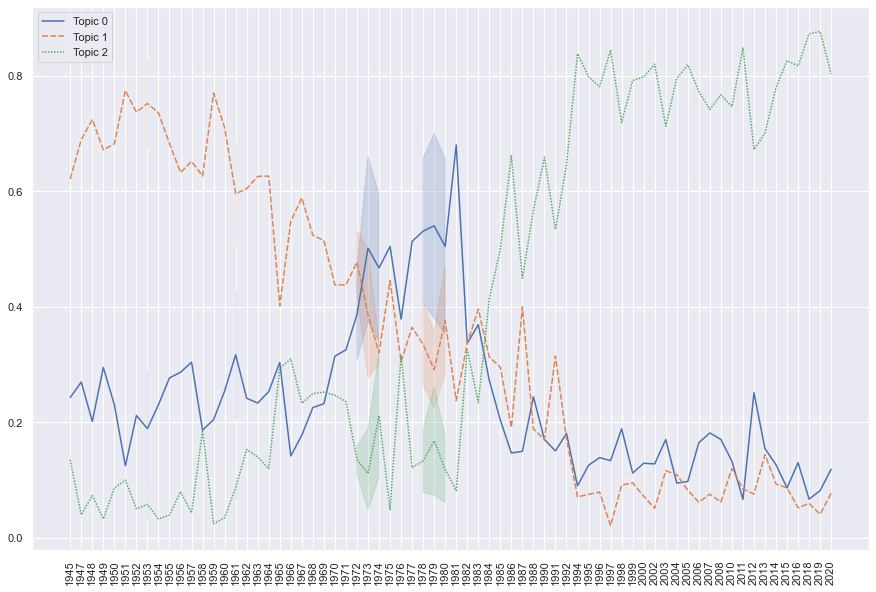

In [44]:
costum_plot(lda_model, cv_fit, 30)

Use `pyLDAvis` to plot Intertopic Distance Map of Topics and Top-30 Most Relevant Terms for each topic 

In [45]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, cv_fit, c_vectorizer_model)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.086041  0.062565       1        1  34.757315
2      0.142503  0.009301       2        1  33.463821
1     -0.056461 -0.071866       3        1  31.778864, topic_info=           Term        Freq       Total Category  logprob  loglift
902     tonight  510.000000  510.000000  Default  30.0000  30.0000
798       shall  315.000000  315.000000  Default  29.0000  29.0000
888       thank  215.000000  215.000000  Default  28.0000  28.0000
139   communist  152.000000  152.000000  Default  27.0000  27.0000
887   terrorist  123.000000  123.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
371     general   77.419992  155.957960   Topic3  -5.7084   0.4460
415     however   74.289527  151.119029   Topic3  -5.7497   0.4363
280  employment   77.806350  242.212637   Topic3  -5.7035   0.0108
134  commission   73.575827  199.542262   Topic3  -5.7594   0.1487
325      farmer   68.419701  140.173862   Topic3  -5.8320   0.4291

[200 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
14        1  0.782288       addition
14        2  0.013846       addition
14        3  0.200764       addition
16        1  0.360552       adequate
16        3  0.635258       adequate
...     ...       ...            ...
984       3  0.024653  work congress
987       1  0.233928    world peace
987       3  0.760265    world peace
997       1  0.016135            yes
997       2  0.984251            yes

[433 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

### NMF 
Non Matrix Factorization using Tf-idf
- `ngram_range`=(1,3), means the lower bound is 1 and upper boundary is 3 from the range of values for different word n-grams.
- `min_df`= 4, removes words with occurrence in less than 4 documents.
- `max_df` = 0.6, ignores the terms that have a document frequency strictly higher than 0.6.
- `max_features`=5000, selects 5000 top features by the score of term frequencey.
- `n_components` = 3, chooses number of topics=3

In [46]:
number_of_topics = 3 #number of topics

In [47]:
# a function to compute TFIDF and NMF
def nmf_costum(docs, n_topics=4):
    tf_vectorizer_model = TfidfVectorizer(analyzer='word', ngram_range=(1,3), token_pattern=pattern, max_df=0.6, min_df=5, max_features=5000)
    tf_fit = tf_vectorizer_model.fit_transform(docs)
    nmf_model = NMF(n_components=n_topics, init='nndsvd', alpha=0.1, l1_ratio=0.1, random_state=100).fit(tf_fit)

    return nmf_model, tf_fit, tf_vectorizer_model
    
# a function to give words of each topic for NMF: number_show can be cahnged
def nmf_display(nmf_model, tf_vectorizer_model):
    names = tf_vectorizer_model.get_feature_names()
    number_show = 10
    for ind, topic in enumerate(nmf_model.components_):
        topic_list = [names[i] for i in np.argsort(topic * -1)[:number_show]]
        print(f"Topic {ind}: {topic_list}")
        

Apply `nmf_costum` function to compute topics and display the top 10 words in each topic using `nmf_display` function.

In [48]:
nmf_model, tf_fit, tf_vectorizer_model = nmf_costum(normlized_doc, n_topics=number_of_topics)
nmf_display(nmf_model, tf_vectorizer_model)

Topic 0: ['shall', 'communist', 'free world', 'farm', 'labor', 'aggression', 'fiscal', 'recommendation', 'atomic', 'expenditure']
Topic 1: ['tonight', 'thank', 'iraq', 'terrorist', 'college', 'parent', 'pas', 'iraqi', 'health care', 'company']
Topic 2: ['oil', 'environmental', 'rural', 'transportation', 'state local', 'regulatory', 'employment', 'ensure', 'urban', 'u.s']


Apply `costum_plot` function to see how much each topic is spoken during the time, we consider top 30 words from each topic

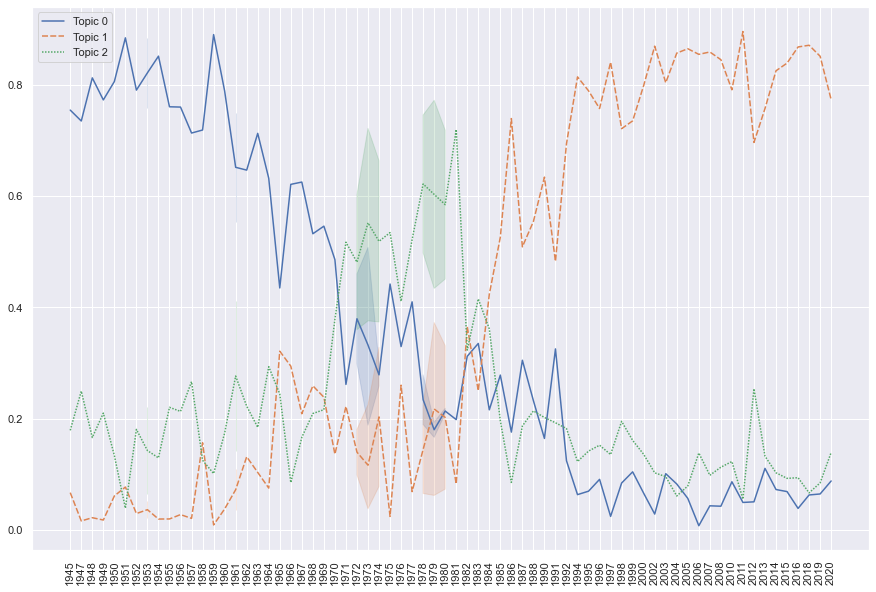

In [49]:
costum_plot(nmf_model, tf_fit, 30)

Use `pyLDAvis` to plot Intertopic Distance Map of Topics and Top-30 Most Relevant Terms for each topic 

In [50]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(nmf_model, tf_fit, tf_vectorizer_model)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.225622  0.045893       1        1  39.798987
0     -0.059305 -0.168085       2        1  36.001753
2     -0.166317  0.122193       3        1  24.199260, topic_info=               Term      Freq     Total Category  logprob  loglift
4017          shall  4.000000  4.000000  Default  30.0000  30.0000
4501        tonight  6.000000  6.000000  Default  29.0000  29.0000
4438          thank  2.000000  2.000000  Default  28.0000  28.0000
727       communist  2.000000  2.000000  Default  27.0000  27.0000
1429  environmental  1.000000  1.000000  Default  26.0000  26.0000
...             ...       ...       ...      ...      ...      ...
2472    legislative  0.914956  1.497522   Topic3  -6.2740   0.9262
859        consumer  0.849378  1.398824   Topic3  -6.3483   0.9200
2910        natural  0.882494  1.640264   Topic3  -6.3101   0.7990
712      commission  0.853251  1.921764   Topic3  -6.3438   0.6069
1428    environment  0.817493  1.424887   Topic3  -6.3866   0.8632

[283 rows x 6 columns], token_table=      Topic      Freq                     Term
term                                          
65        3  0.721472                 addition
69        2  0.651167                 adequate
77        3  1.767745  administration continue
82        3  1.685015      administration work
106       1  1.122866               affordable
...     ...       ...                      ...
4715      2  0.556715                  vietnam
4741      1  0.635343                     vote
4820      2  0.708039                    whole
4864      3  1.865431    work closely congress
4865      3  1.100025            work congress

[181 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])